In [1]:
%gui wx
import sys
import os


notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ





import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()


loadFSL()


import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


import requests
import urllib.request
from tqdm import tqdm


from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt
from fsl.wrappers import mcflirt



import glob
import pandas as pd
import numpy as np
import json
import subprocess

Gtk-Message: 13:15:35.166: Failed to load module "canberra-gtk-module"


In [2]:
def get_json_from_file(fname):
    f = open(fname)
    data = json.load(f)
    f.close()
    return data
    

In [3]:
bids_root='data_mp1' #create a folder manually
dataset_id = 'ds000171'
subject = '01'

import matplotlib.pyplot as plt

deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
anat_path = op.join(bids_root, 'sub-control01', 'anat')

In [ ]:
#subprocess.run(["openneuro-py", "download", "--dataset", dataset_id, "--target-dir", bids_root, "--include", 'sub-control{}'.format(subject)], check=True)

In [6]:
otherfiles_list = [
    
    'dataset_description.json',
    'T1w.json',
    
    'task-music_bold.json',
   
]


def mkdir_no_exist(path):
    if not op.isdir(path):
        os.makedirs(path)
        
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)


for filename in otherfiles_list:
    # Construct the download link for these files
    download_link = f'https://openneuro.org/crn/datasets/{dataset_id}/snapshots/00001/files/{filename}'
    print(f'Attempting download from: {download_link}')
    # Download the file without specifying file_type
    download_url(download_link, op.join(bids_root, 'sub-control01', 'func', filename))
    print('Downloaded:', filename)

Attempting download from: https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/dataset_description.json


dataset_description.json: 8.19kB [00:00, 14.7kB/s]


Downloaded: dataset_description.json
Attempting download from: https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/T1w.json


T1w.json: 8.19kB [00:00, 15.5kB/s]


Downloaded: T1w.json
Attempting download from: https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/task-music_bold.json


task-music_bold.json: 8.19kB [00:00, 15.2kB/s]

Downloaded: task-music_bold.json


In [17]:
fsleyesDisplay = FSLeyesServer()

In [23]:
from nilearn.image import concat_imgs

# Define the paths to your gzipped NIfTI files
file_paths = [
    'sub-control01_task-music_run-1_bold.nii.gz',
    'sub-control01_task-music_run-2_bold.nii.gz',
    'sub-control01_task-music_run-3_bold.nii.gz'

]

def standardize(img):
    data = img.get_fdata()
    mean = np.mean(data)
    std = np.std(data)
    standardized_data = (data - mean) / std
    return nib.Nifti1Image(standardized_data, img.affine)

# Initialize a list to hold standardized data
standardized_data_list = []

# Process each file
for file_path in file_paths:
    img = nib.load(os.path.join(bids_root, 'sub-control01', 'func', file_path))
    
    standardized_data = standardize(img)
    standardized_data_list.append(standardized_data)


concatenated_img = concat_imgs(standardized_data_list)


# Save the concatenated image as a gzipped NIfTI file
#nib.save(concatenated_img, os.path.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold.nii.gz'))

In [24]:
#mkdir_no_exist(bids_root)
mkdir_no_exist(deriv_root)
mkdir_no_exist(preproc_root)
mkdir_no_exist(os.path.join(preproc_root, 'sub-control01'))
mkdir_no_exist(os.path.join(preproc_root, 'sub-control01', 'func'))

path_original_data = os.path.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold')
path_moco_data = os.path.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold_moco')
#mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

Processed data will be saved as data_mp1/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concatenated_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [157] to 8 mm pixels
Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293]

refnum = 157
Original_refvol = -1


Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][156][155][154][153][152][151][150][149][148][147][146][145][144][143][142][141][140][139][138][137][136][135][134][133][132][131][130][129][128][127][126][125][124][123][122][121][120][119][

{}

In [ ]:
fsleyesDisplay.show()
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(path_original_data)
fsleyesDisplay.load(path_moco_data)

In [13]:
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold_moco.par'))
mot_params

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,-0.003267,0.002930,5.552720e-07,-0.059817,-0.518985,-0.470659
1,-0.003333,0.002930,-1.600820e-04,-0.066681,-0.490942,-0.467984
2,-0.003147,0.002880,-1.880300e-04,-0.053630,-0.470922,-0.446214
3,-0.003264,0.003291,-3.337180e-04,-0.067658,-0.483699,-0.463707
4,-0.002729,0.003120,-3.183150e-04,-0.073350,-0.470581,-0.494909
...,...,...,...,...,...,...
310,0.008946,-0.000008,-2.131270e-03,-0.087116,0.400872,0.237711
311,0.009100,-0.000159,-2.114960e-03,-0.084539,0.374362,0.217879
312,0.009154,-0.000425,-1.901570e-03,-0.085075,0.404540,0.224777
313,0.008975,-0.000425,-2.162820e-03,-0.103438,0.370850,0.211481


In [14]:
def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    # Estimating displacement on a 50mm radius sphere
    # To know this one, we can remember the definition of the radian!
    # Indeed, let the radian be theta, the arc length be s and the radius be r.
    # Then theta = s / r
    # We want to determine here s, for a sphere of 50mm radius and knowing theta. Easy enough!
    
    # Another way to think about it is through the line integral along the circle.
    # Integrating from 0 to theta with radius 50 will give you, unsurprisingly, r0 theta.
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()

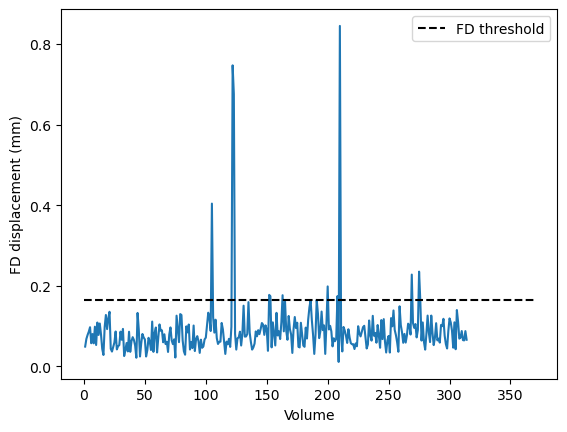

In [15]:
#%matplotlib inline
threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))
plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 370,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

In [16]:
np.where(fd > threshold)[0] + 1

array([105, 122, 123, 152, 153, 163, 186, 191, 200, 208, 210, 269, 275])

SLICE TIMING CORRECTION


In [4]:
d=get_json_from_file(op.join(bids_root, 'sub-control01', 'func', 'dataset_description.json'))


In [5]:
data = get_json_from_file(op.join(bids_root, 'sub-control01', 'func', 'task-music_bold.json'))
slice_timing = data['SliceTiming'] # Replace with the appropriate key (have a look above!)
tr = data['RepetitionTime'] # Extract the TR from the sidecar's appropriate field


In [6]:
slice_order = np.argsort(slice_timing) + 1

# Write to a file the corresponding sorted timings :)
timing_path = op.join(preproc_root,  'sub-control01', 'func', 'sub-control01_task-sitrep_run-01_slice-timings.txt')
file = open(timing_path, mode='w')
for t in slice_order:
    file.write(str(t) + '\n')
file.close()

In [15]:
file_to_realign = op.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold.nii.gz')
output_target = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold_slice-corr.nii.gz')

subprocess.run(['slicetimer', '-i', file_to_realign, '-o', output_target, '-r', str(tr), '-d', str(3), '--ocustom={}'.format(timing_path)])
#cmd = 'slicetimer -i ' + file_to_realign + ' -o ' + output_target + ' -r ' + str(tr) + ' -d 3 --ocustom=' + timing_path
#os.system(cmd)

CompletedProcess(args=['slicetimer', '-i', 'data_mp1/sub-control01/func/sub-control01_task-music_concatenated_bold.nii.gz', '-o', 'data_mp1/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concatenated_bold_slice-corr.nii.gz', '-r', '3.0', '-d', '3', '--ocustom=data_mp1/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-sitrep_run-01_slice-timings.txt'], returncode=0)

In [18]:
output_path = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold_moco.nii.gz')

#cmd = 'fslmaths {} -s {} {}_smoothed-6mm'.format(output_path, 6/2.3548, output_path)
#subprocess.run(['fslmaths',output_path, '-s', str(6/2.3548), '{}_smoothed-6mm'.format(output_path)])

In [26]:
fsleyesDisplay.show()
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(output_path + '_smoothed-6mm')

In [7]:

func_path = op.join(bids_root, 'sub-control01', 'func')



evt1=pd.read_csv(op.join(func_path, 'sub-control01_task-music_run-1_events.tsv'), sep='\t')
evt2=pd.read_csv(op.join(func_path, 'sub-control01_task-music_run-2_events.tsv'), sep='\t')
evt3=pd.read_csv(op.join(func_path, 'sub-control01_task-music_run-3_events.tsv'), sep='\t')


evt_concat=pd.concat([evt1,evt2,evt3], ignore_index=True)
evt_concat['onset']=evt_concat['duration'].cumsum()
evt_concat

,onset,duration,trial_type
0,33.0,33.0,tones
1,36.0,3.0,response
2,67.5,31.5,negative_music
3,70.5,3.0,response
4,102.0,31.5,tones
5,105.0,3.0,response
6,136.5,31.5,positive_music
7,139.5,3.0,response
8,171.0,31.5,tones
9,174.0,3.0,response


In [19]:
import numpy as np

# Set parameters
TR = 3  # Repetition time (in seconds)
total_time = 936  # Total time of the scan in seconds
time_points = np.arange(0, total_time, TR)


In [20]:
from nilearn.glm.first_level import make_first_level_design_matrix

# Generate design matrix using Nilearn's HRF
design_matrix = make_first_level_design_matrix(
    frame_times=time_points,
    events=evt_concat,
    hrf_model='spm',
    drift_model='polynomial'
)

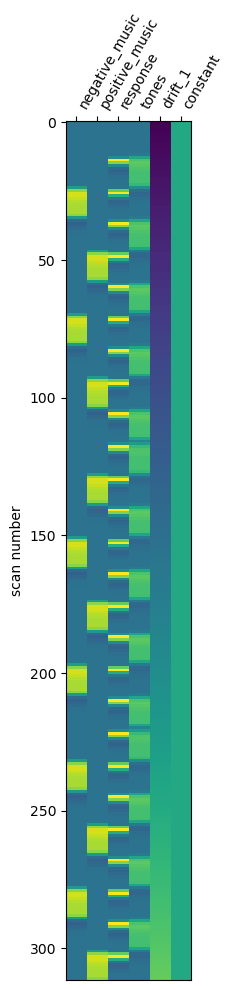

In [21]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(design_matrix)
plt.show()

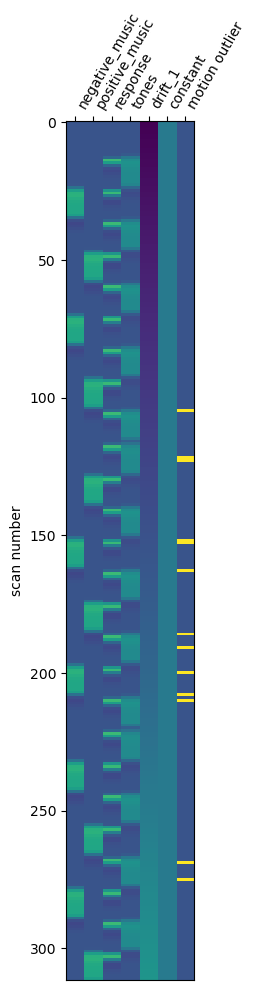

In [23]:
reg = np.zeros((312))
reg[np.where(fd > threshold)[0] + 1] = 1


design_mat_regged = design_matrix.copy()
design_mat_regged['motion outlier'] = reg

plot_design_matrix(design_mat_regged)
plt.show()

In [26]:
fmri_img = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold_moco.nii.gz_smoothed-6mm.nii.gz')

In [27]:
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel

# Specify what sort of GLM we want (nature of the noise, repetition time of the data and other parameters)
fmri_glm = FirstLevelModel(t_r=3,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model=None,
                           high_pass=.01)

# Fit the model to our design and data
fmri_glm = fmri_glm.fit(fmri_img, evt_concat)

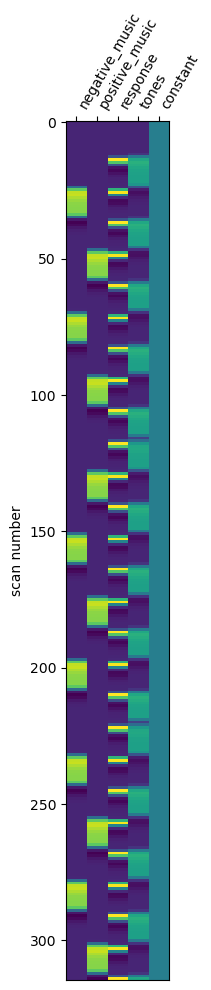

In [28]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(fmri_glm.design_matrices_[0])
plt.show()

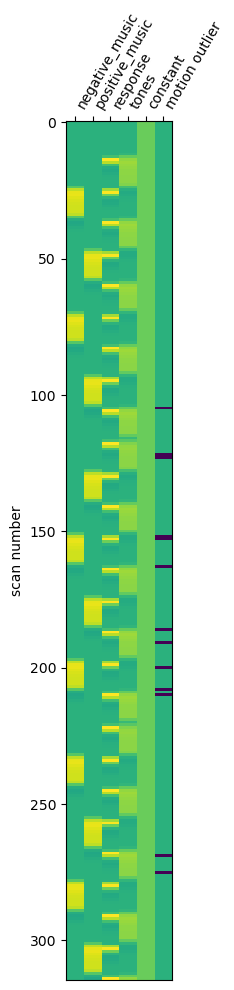

In [63]:
reg = np.zeros((315))
reg[np.where(fd > threshold)[0] + 1] = -1

design_matrix=fmri_glm.design_matrices_[0]
design_mat_regged = design_matrix.copy()
design_mat_regged['motion outlier'] = reg

plot_design_matrix(design_mat_regged)
plt.show()

In [64]:
fmri_glm = fmri_glm.fit(fmri_img, design_matrices=[design_mat_regged])

In [65]:
conditions = {
    'active_neg': np.array([1, 0, 0,0,0]), # Specify the np array, e.g. np.array([2, -1, 0]) to extract active
    'active_pos':np.array([0, 1,0, 0,0]), # Specify the np array, e.g. np.array([2, -1, 0]) to extract rest
    'response':np.array([0, 0,1, 0,0]), # Specify the np array, e.g. np.array([2, -1, 0]) to extract rest
    'rest':np.array([0, 0, 0,1,0]) # Specify the np array, e.g. np.array([2, -1, 0]) to extract rest

}

active_minus_rest = conditions['active_pos'] - conditions['active_neg']
active_minus_rest=np.array([-1, 2, 0,0,0,0])

<Axes: label='conditions'>

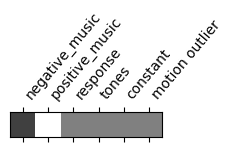

In [66]:
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(active_minus_rest, design_matrix=design_mat_regged)  ####TODO ADD COLOR SCALE

/opt/conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/conda/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



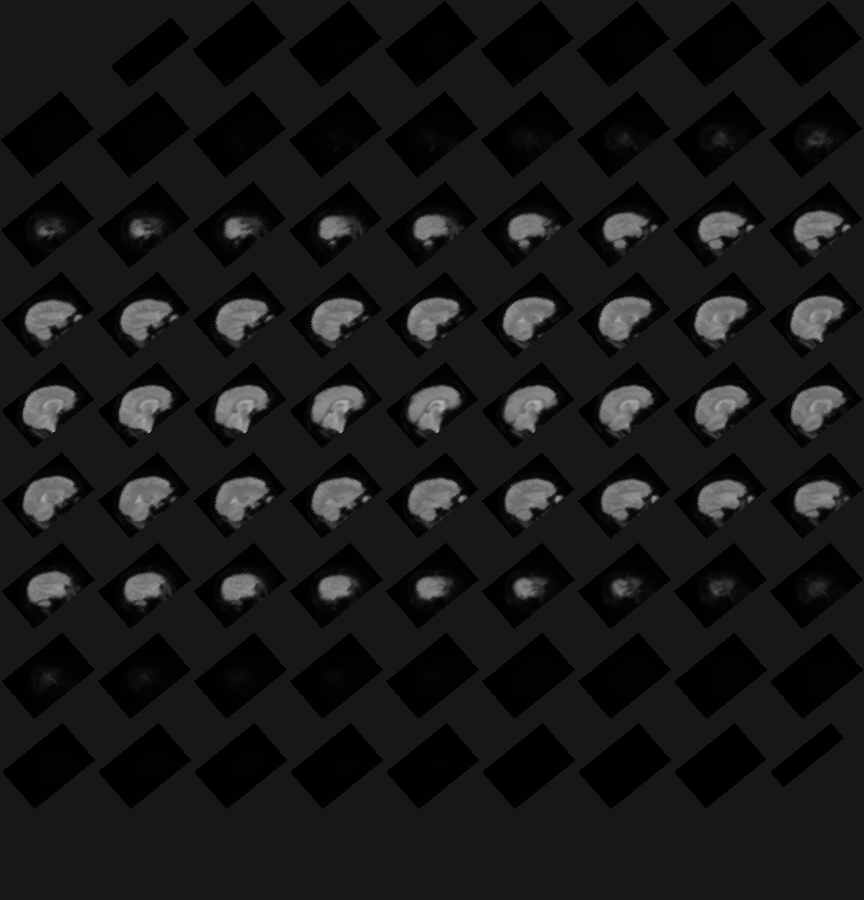
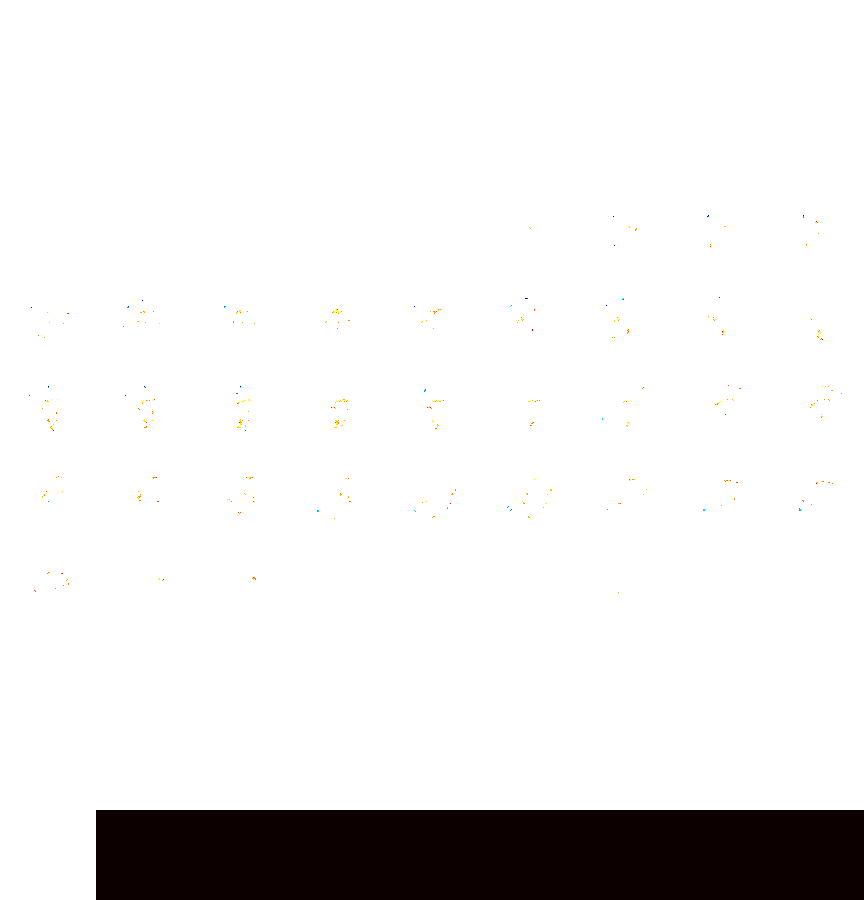

In [68]:
from nilearn.image import mean_img
from nilearn.plotting import view_img
import nibabel as nib

# Assuming fmri_glm and active_minus_rest are defined elsewhere in your code
z_map = fmri_glm.compute_contrast(active_minus_rest, output_type='z_score')

# Save the Z map to a file
nib.save(z_map, 'z_map_uncorrected.nii.gz')

# Compute the mean image
mean_img_ = mean_img(fmri_img)

# Use view_img for 3D visualization
view = view_img(z_map, bg_img=mean_img_, threshold=2.0, title='Active minus Rest (Z>2)')

# Display the interactive view within the notebook
view



Added README.md to /home/jovyan/nilearn_data


Dataset created in /home/jovyan/nilearn_data/aal_SPM12



 ...done. (1 seconds, 0 min)
Extracting data from /home/jovyan/nilearn_data/aal_SPM12/a4f2a6316ec7f29f771edef840308edf/aal_for_SPM12.tar.gz..... done.
/opt/conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



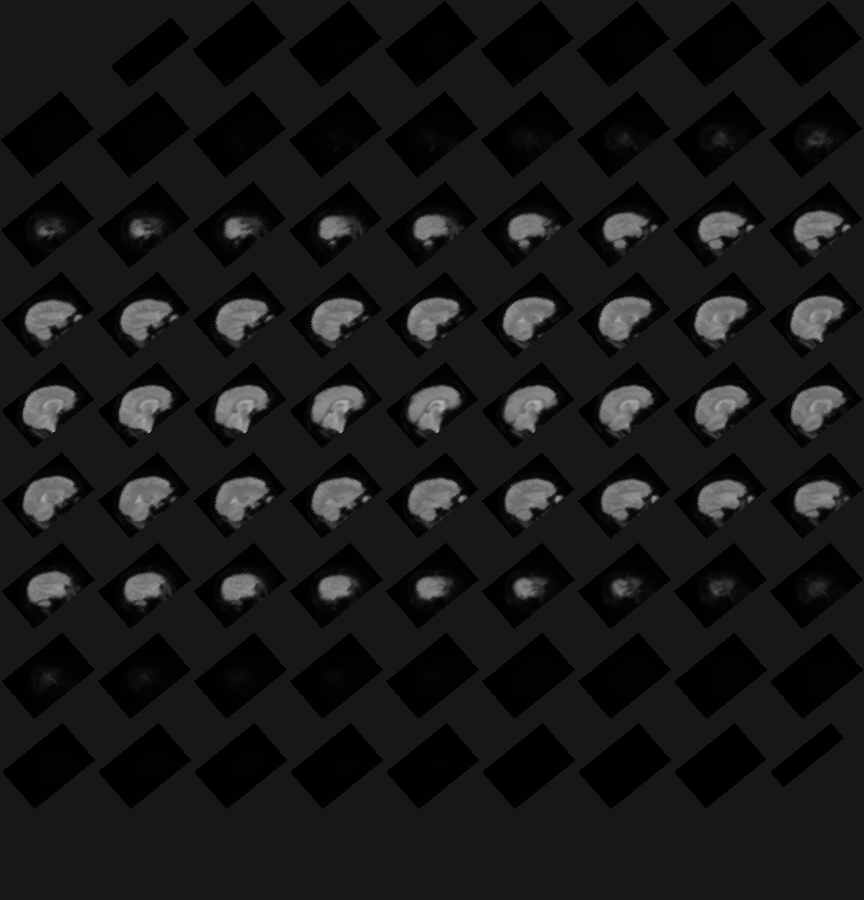
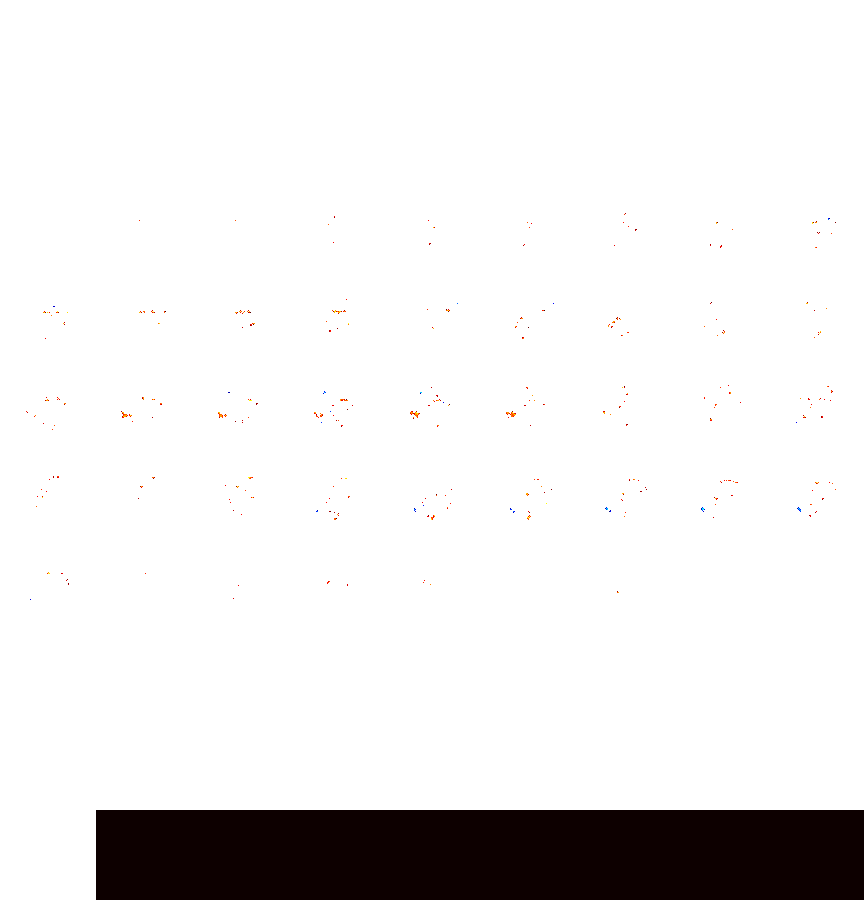

In [34]:
from nilearn import plotting, image, datasets
import nibabel as nib

# Assuming fmri_glm and active_minus_rest are defined elsewhere in your code
z_map = fmri_glm.compute_contrast(active_minus_rest, output_type='z_score')

# Save the Z map to a file
nib.save(z_map, 'z_map_uncorrected.nii.gz')

# Compute the mean image
mean_img_ = image.mean_img(fmri_img)

# Threshold the z-map to create a mask for significant areas
thresholded_z_map = image.threshold_img(z_map, threshold=1.5)

# Fetch the AAL atlas
aal_atlas = datasets.fetch_atlas_aal()

# Use view_img for 3D visualization
view = plotting.view_img(thresholded_z_map, bg_img=mean_img_, title='Highlighted Zones of Interest')


# Display the interactive view
view


/opt/conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/conda/lib/python3.11/site-packages/nilearn/image/resampling.py:756: UserWarning: Casting data from int32 to float32
  return resample_img(



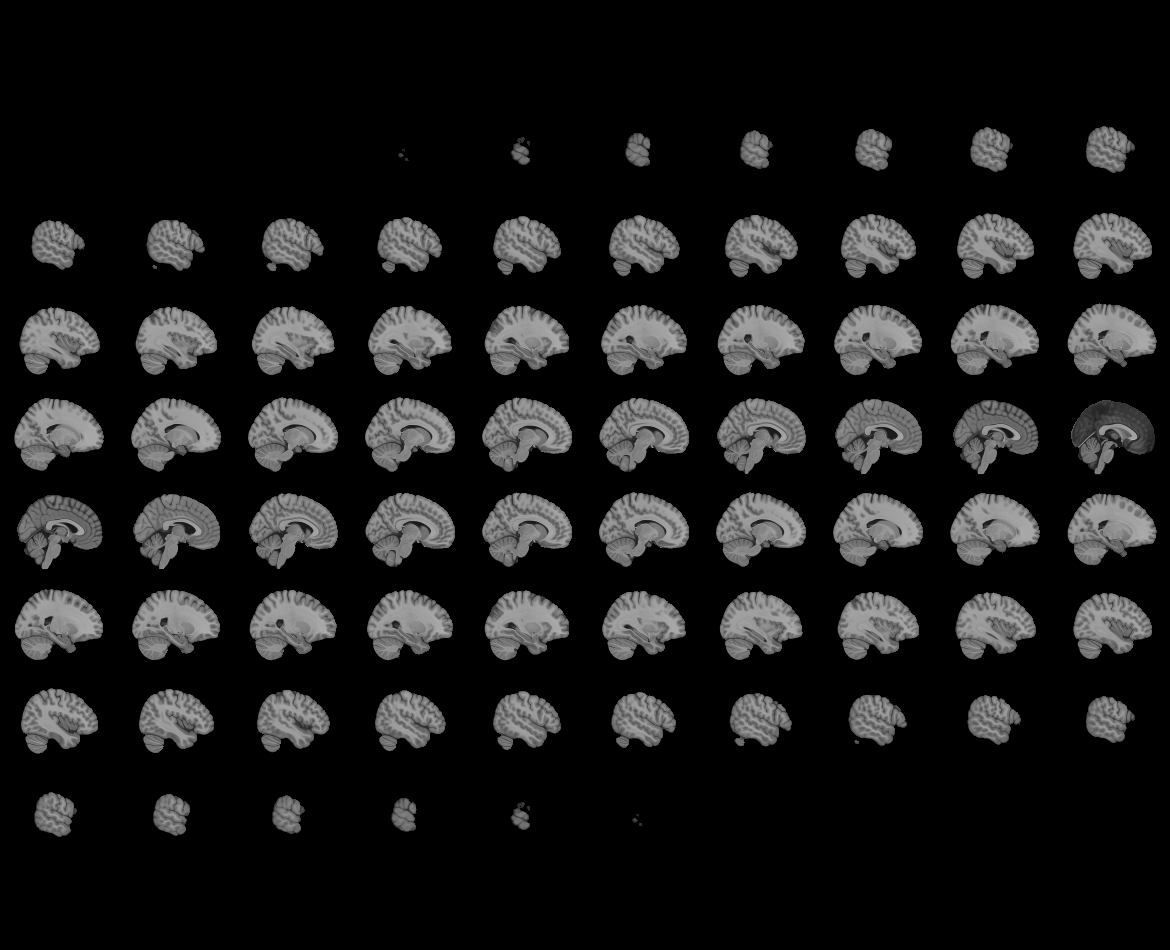
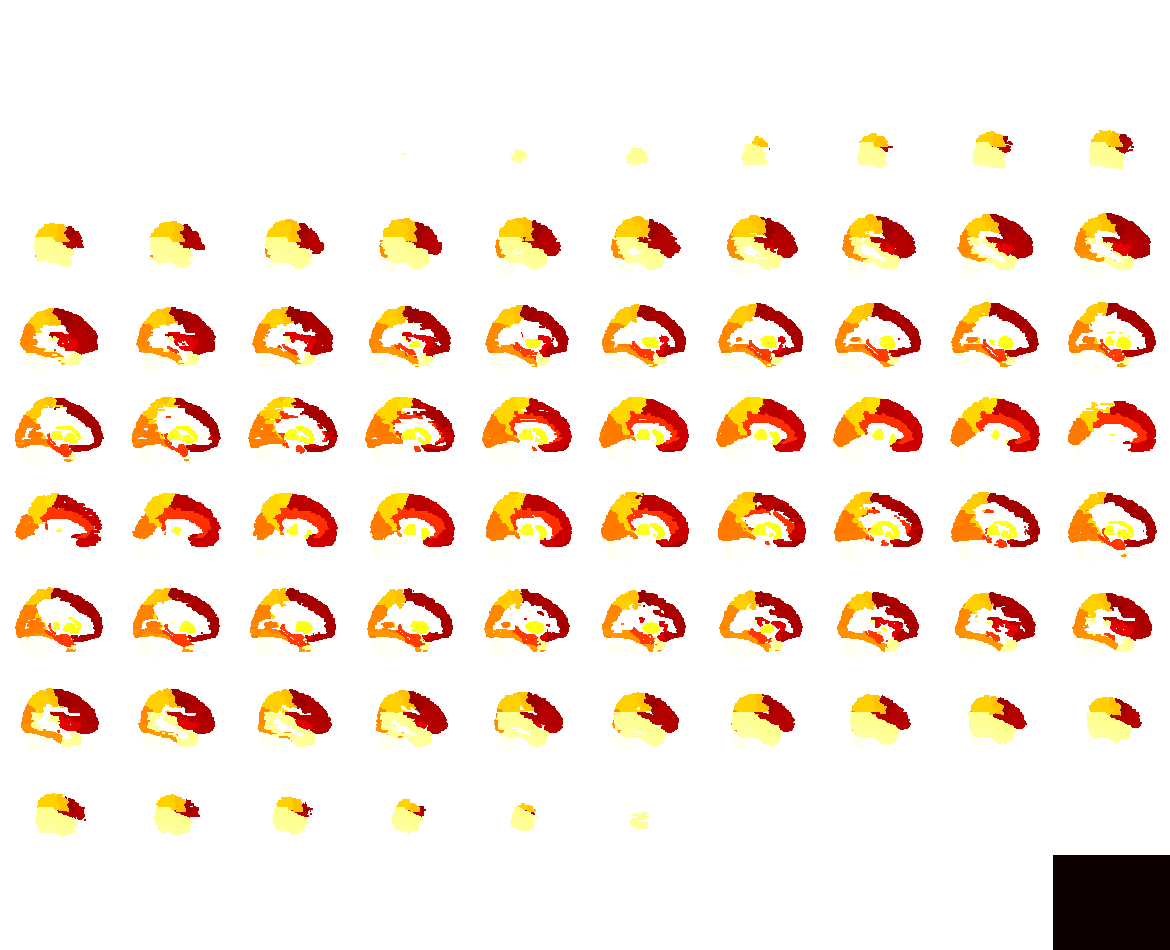

In [36]:
# Use view_img for 3D visualization
view = plotting.view_img(aal_atlas.maps)


# Display the interactive view
view


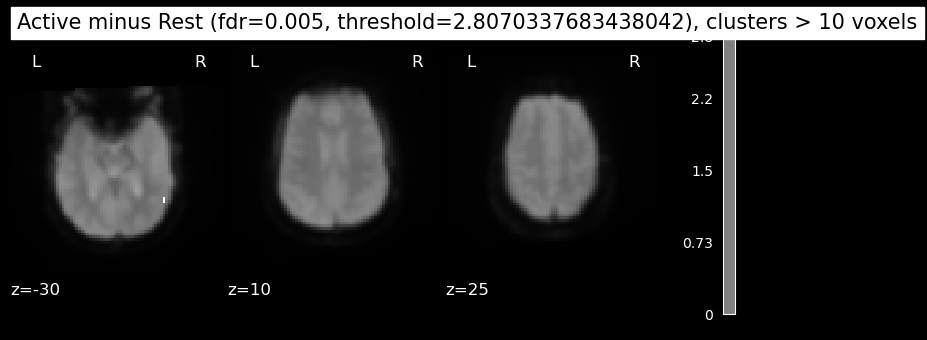

In [51]:
from nilearn.glm import threshold_stats_img

#Link to threshold_stats_img function documentation
#https://nilearn.github.io/dev/modules/generated/nilearn.glm.threshold_stats_img.html

cluster_size = 10 # Fill me with the number of voxels for a cluster to be kept
fdr_rate = 0.005# Fill me with the fdr rate to use!

# Here, we apply the FDR correction + threshold
clean_map, threshold = threshold_stats_img(z_map, alpha=fdr_rate, height_control='fpr', cluster_threshold=cluster_size)

# And this is just to plot here!
plot_stat_map(clean_map, bg_img=mean_img_[0], threshold=threshold,
              display_mode='z', cut_coords=[-30,10,25], black_bg=True,
              title='Active minus Rest (fdr={}, threshold={}), clusters > {} voxels'.format(fdr_rate, threshold, cluster_size))
plt.show()